In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xgboost   # 导入xgboost库
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#from feature_selector import FeatureSelector
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier  #导入sklearn分类API

In [2]:
X=pd.read_csv("Kmer5.csv",header=None)
y=pd.read_csv("label.csv",header=None)

In [3]:
data=pd.concat((X,y),axis=1)
data=np.array(data)
print(data.shape)
np.random.seed(612)
np.random.shuffle(data) 
data_X=data[:,0:-1]
data_y=data[:,-1]

(173, 1025)


In [4]:
transfer=StandardScaler()
Standard_X=transfer.fit_transform(data_X)  #在该数据集中StandardScaler比MinMaxScaler用的好，数据整体精确度提高
Standard_Y=data_y
#print(Standard_X.var())

In [5]:
cv=LeaveOneOut()

In [6]:
print(datetime.datetime.now())
estimator=XGBClassifier()
acc_val=cross_val_score(estimator,Standard_X,Standard_Y,scoring="accuracy",cv=cv)
print(datetime.datetime.now())
print("the mean score of cross validation:{:.3f}".format(np.mean(acc_val)))

2022-02-15 19:33:15.467464
2022-02-15 19:33:48.865590
the mean score of cross validation:0.786


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

2022-02-15 19:33:49.140854
2022-02-15 19:35:39.122598
best parameters:{'n_estimators': 60}
best cross-validation score:0.803
best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


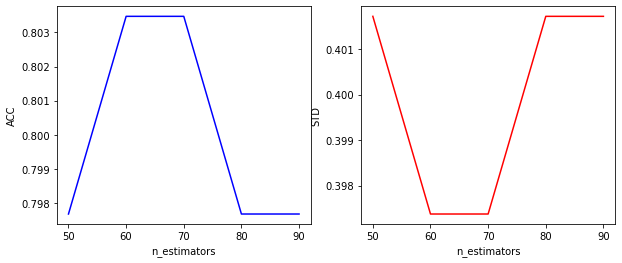

In [8]:
print(datetime.datetime.now())
param1=np.array(range(50,100,10))
param_grid={"n_estimators":param1}
grid_search=GridSearchCV(XGBClassifier(),param_grid,scoring="accuracy",cv=cv)
grid_search.fit(Standard_X,Standard_Y)
print(datetime.datetime.now())
print("best parameters:{}".format(grid_search.best_params_))                        
print("best cross-validation score:{:.3f}".format(grid_search.best_score_))         
print("best estimator:\n{}".format(grid_search.best_estimator_))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.ylabel("ACC")
plt.xlabel("n_estimators")
plt.plot(param_grid["n_estimators"],grid_search.cv_results_['mean_test_score'],color="blue")
plt.subplot(122)
plt.ylabel("STD")
plt.xlabel("n_estimators")
plt.plot(param_grid["n_estimators"],grid_search.cv_results_['std_test_score'],color="red")
plt.show()

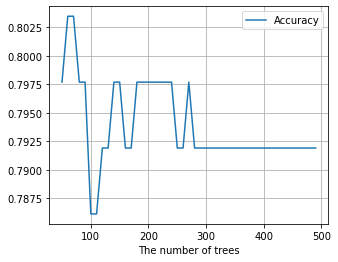

In [10]:
accuracy_a=[]
pre_a=[]
rec_a=[]
f1_a=[]
auroc_a=[]
for i in np.array(range(50,500,10)):
    Predict_Y=[]    
    Prob_Y=[]       
    Really_Y=Standard_Y
    for train_index,test_index in cv.split(Standard_X):
        estimator=XGBClassifier(n_estimators=i)
        estimator.fit(Standard_X[train_index],Standard_Y[train_index])
        Predict_Y.append(estimator.predict(Standard_X[test_index])[0])
        Prob_Y.append(estimator.predict_proba(Standard_X[test_index]))
    Prob_Y=np.array(Prob_Y)  
    Prob_Y=Prob_Y.reshape(173,2)  
    import pandas as pd
    Prob_Y=pd.DataFrame(Prob_Y)
    Prob_Y.columns=["0","1"]
    confusion_matrix(Really_Y,Predict_Y)
    ACC=accuracy_score(Really_Y,Predict_Y)
    Rec=recall_score(Really_Y,Predict_Y)
    Pre=precision_score(Really_Y,Predict_Y)
    F1_score=f1_score(Really_Y,Predict_Y)
    AUC=roc_auc_score(Really_Y,np.array(Prob_Y["1"]))
    
    accuracy_a.append(ACC)
    rec_a.append(Rec)
    pre_a.append(Pre)
    f1_a.append(F1_score)
    auroc_a.append(AUC)
    
results=np.array([accuracy_a,rec_a,pre_a,f1_a,auroc_a])
result_final = pd.DataFrame(results)
result_final.to_csv('k1.csv')
plt.figure(figsize=(5,4))
plt.plot(np.array(range(50,500,10)),accuracy_a,label="Accuracy")
#plt.plot(np.array(range(50,500,10)),f1_a,label="F1_score")
#plt.plot(np.array(range(50,500,10)),auroc_a,label="AUROC")
plt.xlabel("The number of trees")
plt.legend()
plt.grid()
plt.show()

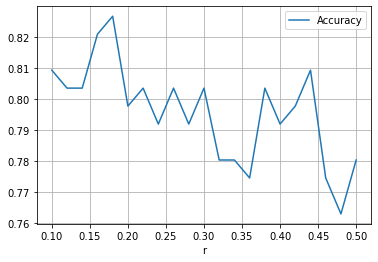

In [11]:
accuracy_b=[]
rec_b=[]
pre_b=[]
f1_b=[]
auroc_b=[]
for i in np.array(range(10,52,2))/100:
    Predict_Y=[]    #存放预测值
    Prob_Y=[]       #存放预测概率
    Really_Y=Standard_Y
    for train_index,test_index in cv.split(Standard_X):
        estimator=XGBClassifier(n_estimators=60,learning_rate=i)
        estimator.fit(Standard_X[train_index],Standard_Y[train_index])
        Predict_Y.append(estimator.predict(Standard_X[test_index])[0])
        Prob_Y.append(estimator.predict_proba(Standard_X[test_index]))
    Prob_Y=np.array(Prob_Y)  #将Prob_Y改为numpy数组形式
    Prob_Y=Prob_Y.reshape(173,2)  #原本是(173,1,2)形状，改为（173,2）形状
    import pandas as pd
    Prob_Y=pd.DataFrame(Prob_Y)
    Prob_Y.columns=["0","1"]
    confusion_matrix(Really_Y,Predict_Y)
    ACC=accuracy_score(Really_Y,Predict_Y)
    Rec=recall_score(Really_Y,Predict_Y)
    Pre=precision_score(Really_Y,Predict_Y)
    F1_score=f1_score(Really_Y,Predict_Y)
    AUC=roc_auc_score(Really_Y,np.array(Prob_Y["1"])) 
    accuracy_b.append(ACC)
    rec_b.append(Rec)
    pre_b.append(Pre)
    f1_b.append(F1_score)
    auroc_b.append(AUC)
results=np.array([accuracy_b,rec_b,pre_b,f1_b,auroc_b])
result_final = pd.DataFrame(results)
result_final.to_csv('k2.csv',index=False)
plt.plot(np.array(range(10,52,2))/100,accuracy_b,label="Accuracy")
#plt.plot(np.array(range(50,500,10)),f1_a,label="F1_score")
#plt.plot(np.array(range(50,500,10)),auroc_a,label="AUROC")
plt.xlabel("r")
plt.legend()
plt.grid()
plt.show()


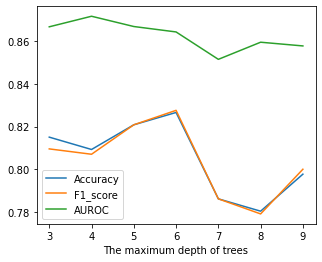

In [12]:
accuracy_c=[]
rec_c=[]
pre_c=[]
f1_c=[]
auroc_c=[]
for i in np.array(range(3,10,1)):
    Predict_Y=[]    #存放预测值
    Prob_Y=[]       #存放预测概率
    Really_Y=Standard_Y
    for train_index,test_index in cv.split(Standard_X):
        estimator=XGBClassifier(n_estimators=60,learning_rate=0.18 ,max_depth=i)
        estimator.fit(Standard_X[train_index],Standard_Y[train_index])
        Predict_Y.append(estimator.predict(Standard_X[test_index])[0])
        Prob_Y.append(estimator.predict_proba(Standard_X[test_index]))
    Prob_Y=np.array(Prob_Y)  #将Prob_Y改为numpy数组形式
    Prob_Y=Prob_Y.reshape(173,2)  #原本是(173,1,2)形状，改为（173,2）形状
    import pandas as pd
    Prob_Y=pd.DataFrame(Prob_Y)
    Prob_Y.columns=["0","1"]
    confusion_matrix(Really_Y,Predict_Y)
    ACC=accuracy_score(Really_Y,Predict_Y)
    Rec=recall_score(Really_Y,Predict_Y)
    Pre=precision_score(Really_Y,Predict_Y)
    F1_score=f1_score(Really_Y,Predict_Y)
    AUC=roc_auc_score(Really_Y,np.array(Prob_Y["1"])) 
    accuracy_c.append(ACC)
    rec_c.append(Rec)
    pre_c.append(Pre)
    f1_c.append(F1_score)
    auroc_c.append(AUC)
results=np.array([accuracy_c,rec_c,pre_c,f1_c,auroc_c])
result_final = pd.DataFrame(results)
result_final.to_csv('k3.csv',index=False)
plt.figure(figsize=(5,4))
plt.plot(np.array(range(3,10,1)),accuracy_c,label="Accuracy")
plt.plot(np.array(range(3,10,1)),f1_c,label="F1_score")
plt.plot(np.array(range(3,10,1)),auroc_c,label="AUROC")
plt.xlabel("The maximum depth of trees")
plt.legend()

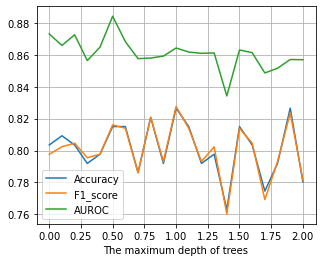

In [13]:
accuracy_d=[]
rec_d=[]
pre_d=[]
f1_d=[]
auroc_d=[]
for i in np.array(range(0,21,1))/10:
    Predict_Y=[]    #存放预测值
    Prob_Y=[]       #存放预测概率
    Really_Y=Standard_Y
    for train_index,test_index in cv.split(Standard_X):
        estimator=XGBClassifier(n_estimators=60,learning_rate=0.18,max_depth=6,reg_lambda=i)
        estimator.fit(Standard_X[train_index],Standard_Y[train_index])
        Predict_Y.append(estimator.predict(Standard_X[test_index])[0])
        Prob_Y.append(estimator.predict_proba(Standard_X[test_index]))
    Prob_Y=np.array(Prob_Y)  #将Prob_Y改为numpy数组形式
    Prob_Y=Prob_Y.reshape(173,2)  #原本是(173,1,2)形状，改为（173,2）形状
    import pandas as pd
    Prob_Y=pd.DataFrame(Prob_Y)
    Prob_Y.columns=["0","1"]
    confusion_matrix(Really_Y,Predict_Y)
    ACC=accuracy_score(Really_Y,Predict_Y)
    Rec=recall_score(Really_Y,Predict_Y)
    Pre=precision_score(Really_Y,Predict_Y)
    F1_score=f1_score(Really_Y,Predict_Y)
    AUC=roc_auc_score(Really_Y,np.array(Prob_Y["1"])) 
    accuracy_d.append(ACC)
    rec_d.append(Rec)
    pre_d.append(Pre)
    f1_d.append(F1_score)
    auroc_d.append(AUC)
results=np.array([accuracy_d,rec_d,pre_d,f1_d,auroc_d])
result_final = pd.DataFrame(results)
result_final.to_csv('k4.csv',index=False)
plt.figure(figsize=(5,4))
plt.plot(np.array(range(0,21,1))/10,accuracy_d,label="Accuracy")
plt.plot(np.array(range(0,21,1))/10,f1_d,label="F1_score")
plt.plot(np.array(range(0,21,1))/10,auroc_d,label="AUROC")
plt.xlabel("The maximum depth of trees")
plt.legend()
plt.grid()
plt.show()

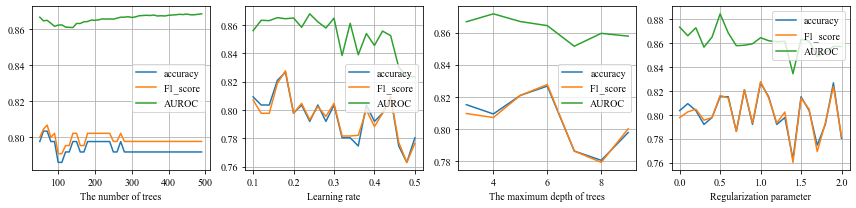

In [18]:
plt.figure(figsize=(12,3))
plt.rc('font',family="Times New Roman")
plt.subplot(141)
plt.plot(np.array(range(50,500,10)),accuracy_a,label="accuracy")
plt.plot(np.array(range(50,500,10)),f1_a,label="F1_score")
plt.plot(np.array(range(50,500,10)),auroc_a,label="AUROC")
plt.xlabel("The number of trees")
#plt.title('(A)',loc='left')  
plt.legend()
plt.grid()
#plt.show()
plt.subplot(142)
plt.plot(np.array(range(10,52,2))/100,accuracy_b,label="accuracy")
plt.plot(np.array(range(10,52,2))/100,f1_b,label="F1_score")
plt.plot(np.array(range(10,52,2))/100,auroc_b,label="AUROC")
plt.xlabel("Learning rate")
#plt.title('(B)',loc='left')
plt.legend(loc="center right")
plt.grid()

plt.subplot(143)
plt.plot(np.array(range(3,10,1)),accuracy_c,label="accuracy")
plt.plot(np.array(range(3,10,1)),f1_c,label="F1_score")
plt.plot(np.array(range(3,10,1)),auroc_c,label="AUROC")
plt.xlabel("The maximum depth of trees")
plt.legend()
#plt.title('(C)',loc='left')
plt.grid()

plt.subplot(144)
plt.plot(np.array(range(0,21,1))/10,accuracy_d,label="accuracy")
plt.plot(np.array(range(0,21,1))/10,f1_d,label="F1_score")
plt.plot(np.array(range(0,21,1))/10,auroc_d,label="AUROC")
plt.xlabel("Regularization parameter")
plt.legend()
plt.grid()
#plt.title('(D)',loc='left')
plt.tight_layout()

#plt.show()

plt.savefig("./Kmer.tif",dpi=300)
plt.savefig("./Kmer.svg",dpi=300)
plt.savefig("./Kmer.png",dpi=300)